<a href="https://colab.research.google.com/github/laura-turnbull-lloyd/IGR_remote_sensing/blob/main/IGR_2025_26_WS03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IGR Workshop 2: Introduction to remote sensing

_Laura Turnbull-Lloyd, IGR, 2026._

During the field trip to Langdon Beck, you collected observations of landscape form and catchment characteristics at specific locations. Remote sensing provides a complementary way to characterise the Earth's surface continuously across space, helping us place those point measurements in a wider catchment context.

This workshop will introduce you to remote sensing of surface characteristics using Python. We will cover data loading, visualizing data, calculating spectral indices, and linking your remote sensing analysis to data you collected in the field.

As you work through the material, you will see some questions. These are so that you can check your comprehension as you go through the content. You can answer the questions [here](https://forms.office.com/e/RK2hGQkqyj).

Note that this is not an assessment - it is just for you to check your understanding.


By the end of this workshop, you will be able to:
*   Load remote sensing data
*   View different spectral band combinations to enhance the visualization of certain features
*   Calculate indices
*   Crop data to the Langdon Beck catchment area
*   Summarize data
*   Link the remote sensing indices to your field-based characterization of surface cover.

## Why is remote sensing important?
Remote sensing is especially useful in Langdon Beck and other upland peatland catchments, and across terrestrial systems more generally, because it lets you see patterns and change that are hard to capture from field points alone.

* It is particularly useful to capture spatial variability in surface propoerties across large areas
* It gives repeat coverage (we'll come on to this next week)
* Vegetation indices relate to productivity and vegetation composition, which connect to carbon uptake, peat stability, and habitat quality.
* It can be used to upscale point measurements (like the ones you collected) and provide spatial inputs/validation for hydrological and geomorphological analyses.

## Data you'll work with
This week you're going to work with Landsat data from August last year (the only cloud-free image near to the time of your field trip!).

The data were downloaded from the USGS Earth Explorer website: earthexplorer.usgs.gov. The image below shows what the web interface looks like, and you can see the location of the Langdon Beck Catchment outlined in red.
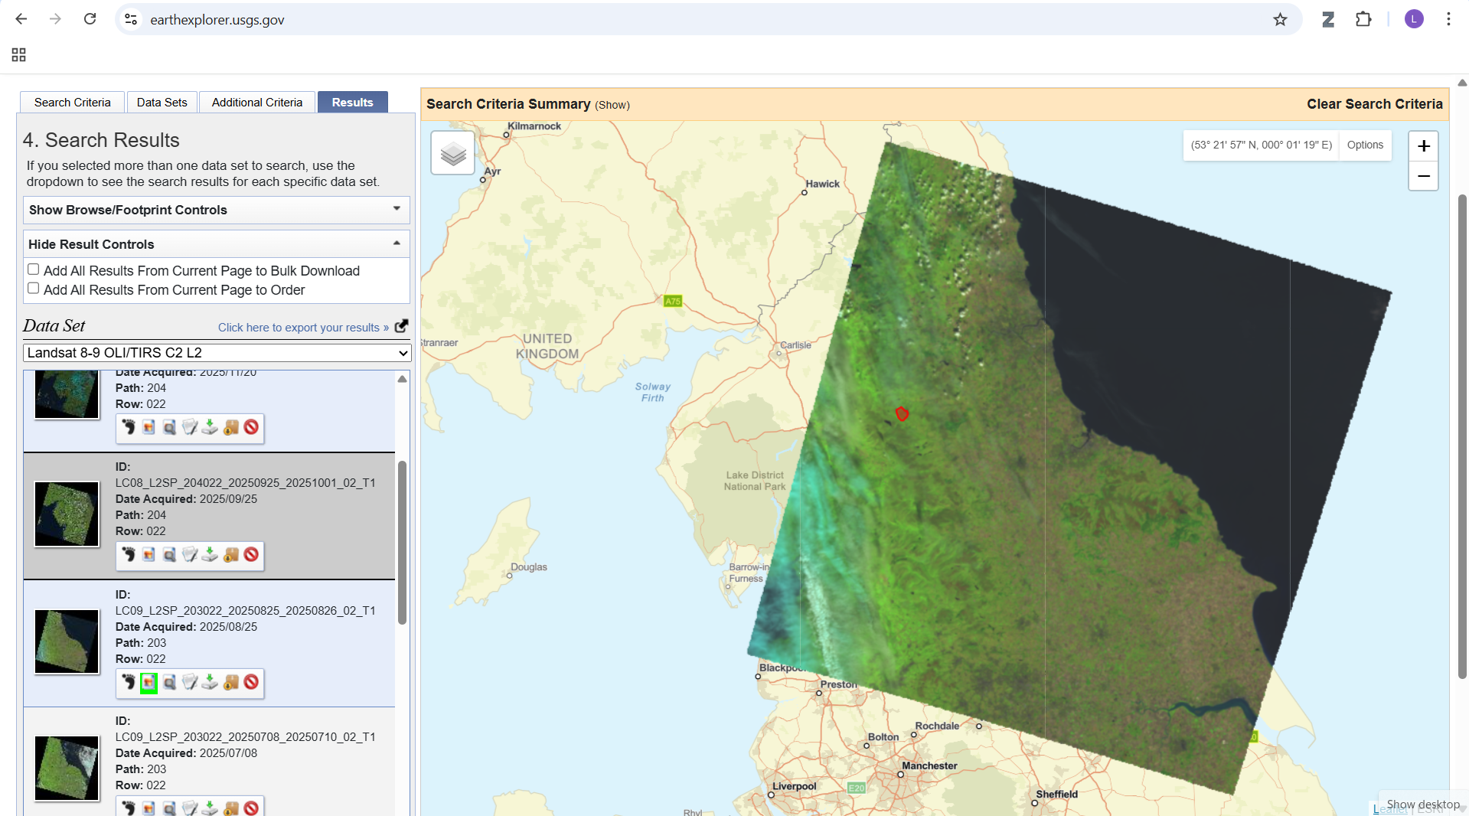



# Houskeeping!
The format of this notebook is as follows. There are blocks of text, such as this one that provide background information/explain what you are about to do.

Then there are code blocks which contain python code ``formatted like this`` that you will run (by clicking on the little green arrow at the top left of each code block).

There are comments inside each code block start with a ``#``, and provide further infromation on what the code block or each line of code does.  

Sometimes you will be asked to recycle code from one block and paste it into another code block, making any required changes. This is often how we work when we're coding -- we use existing code and repurpose it for the task in hand.

#Getting started

First, you'll install the packages we'll use. These are the toolboxes that provide the functions needed for the analysis.

Remote sensing data are raster data, and are often stored in a GeoTIFF data format, the same as the format of the LiDAR DEM last week. Following on from last week, we will continue to use the  _rasterio_ library, as well as the _matplotlib_ library for plotting data.


In [ ]:
#@title Run this block once to install the packages
print("Installing rasterio...")
!pip install -q rasterio --quiet
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
#from xml.dom import minidom
import requests
from tqdm import tqdm
#import os
print("Libraries installed and imported")
#Open the images and metadata from the web



Load a function to download the data stored in a url link:

In [ ]:
#@title Run this block once to load a function that allows you to download data from a web link

# The code below is a function to download the data from a web link, and display a download progress bar.
# You don't need to understand the detail here, but note that this function might be useful in future! It can be applied to any dataset stored in a web link.

def download_file(url, filename):
    """Downloads a file from a URL and displays a progress bar.

    Args:
        url: The URL of the file to download.
        filename: The name to save the file as.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        total_size = int(response.headers.get('content-length', 0)) or None # Handle missing Content-Length
        block_size = 1024

        with open(filename, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=filename) as pbar:
                for data in response.iter_content(block_size):
                    if data:  # Filter out keep-alive new chunks
                        f.write(data)
                        pbar.update(len(data))

        #print(f"{filename} downloaded successfully.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")
    except Exception as e:  # Catch other potential errors
        print(f"An unexpected error occurred downloading {filename}: {e}")


Now time for the fun part.

# Landsat imagery

Landsat 8 and Landsat 9 Operational Land Imager (OLI) and Thermal Infrared Sensor (TIRS) images consist of nine spectral bands, and two thermal bands. The approximate scene size is 170 km north-south by 183 km east-west (106 mi by 114 mi).

We will be working with a Landsat Level 2 collection. These data are available for the following time periods:
Landsat 8 OLI/TIRS: April 2013 to Present
Landsat 9 OLI/TIRS: January 31, 2022 to Present.

More information about these data are provided [here](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-olitirs-collection-2-level-2).


The Landsat data provided for you are not full Landsat tiles (they're huge). Instead the data have been cropped for you, to an extent that encompasses the Langdon Beck catchment.

The data are provided for you on my GitHub page (a website dedicated to sharing code/resources), and you can download the data by directly connecting to the web link for each data file.

The code below downloads the data for you. It creates a list of files to download (structured with the url and the file name) and then runs the function you loaded before to download each file in a loop.

In [ ]:
#@title Download the Landsat data

# This code creates a list of web links and file names -- one for each band of Landsat data that we're downloading.
files = [
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B1_crop.tif", "LangdonBeck_B1"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B2_crop.tif", "LangdonBeck_B2"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B3_crop.tif", "LangdonBeck_B3"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B4_crop.tif", "LangdonBeck_B4"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B5_crop.tif", "LangdonBeck_B5"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B6_crop.tif", "LangdonBeck_B6"),
    ("https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/LC09_L2SP_203022_20250825/LC09_L2SP_203022_20250825_20250826_02_T1_SR_B7_crop.tif", "LangdonBeck_B7")
]

# This is a loop, and for each file in the list we've just created (called files), we run the download_file function to download the data
for url, filename in files:
    download_file(url, filename)

print("\nDownload Complete")

The names of Landsat images provide lots of useful information. The name of the first file you've downloaded is: **LC09_L2SP_203022_20250825_20250826_02_T1_SR_B1**

This can be decoded as follows:

LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX_data_band

where,

* L = Landsat
* X = Sensor ("C"=OLI/TIRS combined, "O"=OLI-only, "T"=TIRS-only, "E"=ETM+, "T"=TM, "M"=MSS)
* SS = Satellite ("08"=Landsat 8, "09" = Landsat 9)
* LLL = Processing correction level (L1TP/L1GT/L1GS)
* PPP = WRS path
* RRR = WRS row
* YYYYMMDD = Acquisition year, month, day
* yyyymmdd - Processing year, month, day
* CC = Collection number (01, 02, …)
* TX = Collection category ("RT"=Real-Time, "T1"=Tier 1, "T2"=Tier 2)
* data = Pixel data type (SR = surface reflectance)
* band = The spectral band of the data file

### Question 1: What date was the data you have downloaded acquired by the Landsat sensor?


### Question 2: What is the path and row of the Landsat scene?

# Landsat data bands

The sensors onboard each of the Landsat satellites were designed to acquire data in different wavelengths within the electromagnetic spectrum.

For Landsat 9 data, there are 11 bands (we're only going to work with data for the first 7 bands today).


# 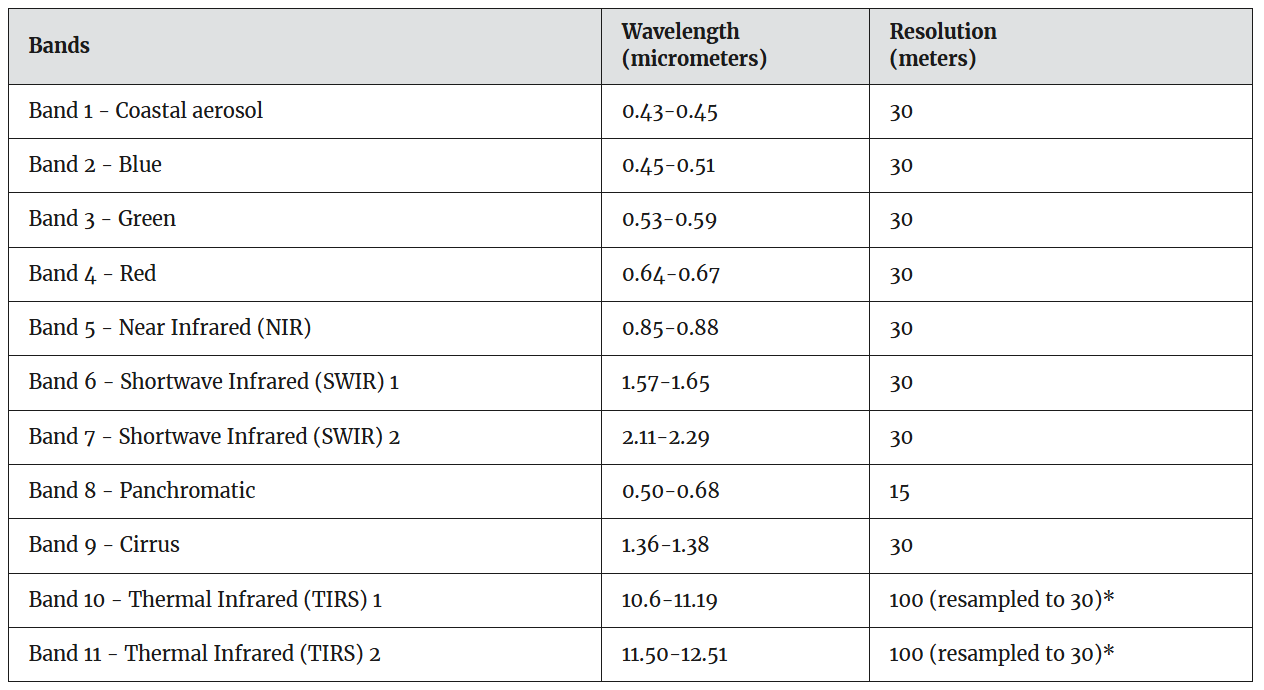

Now you know what the different bands represent, let's have a go at opening the data.

In [ ]:
#@title Read in a single band (layer) of data using the rasterio package

band = "B1"
image_file = "LangdonBeck_" + band
print(image_file)

with rasterio.open(image_file) as src:
    band1 = src.read(1)

If we print out the data we've just read in (using the ``print`` command), we can see a sample of the numeric values that make up the band 1 data:

In [ ]:
print(band1)

So, every cell in the raster dataset contains a digital value, which is what you've just printed out above.

We can also check the dimensions of the data (i.e. the number of cells (values)) in the x and y dimensions, as well as the number of layers in the dataset using the ``shape`` command:

In [ ]:
band1.shape

This output tells you the number of cells in the x and y directions.

### Question 3: You were already told the resolution of Band 1 Landsat data. Use information on the dimensions of the dataset to calculate the area covered by this image.


# Importing all bands of data into a stack
The above example showed you how to import and explore information for a single band (spectral layer).

For some tasks, it is useful to have the data stored in such a way that enables us to work with different layers easily.

We can do this my importing the data for different spectral bands into a single file, that has several layers. This is illustrated in the diagram below.

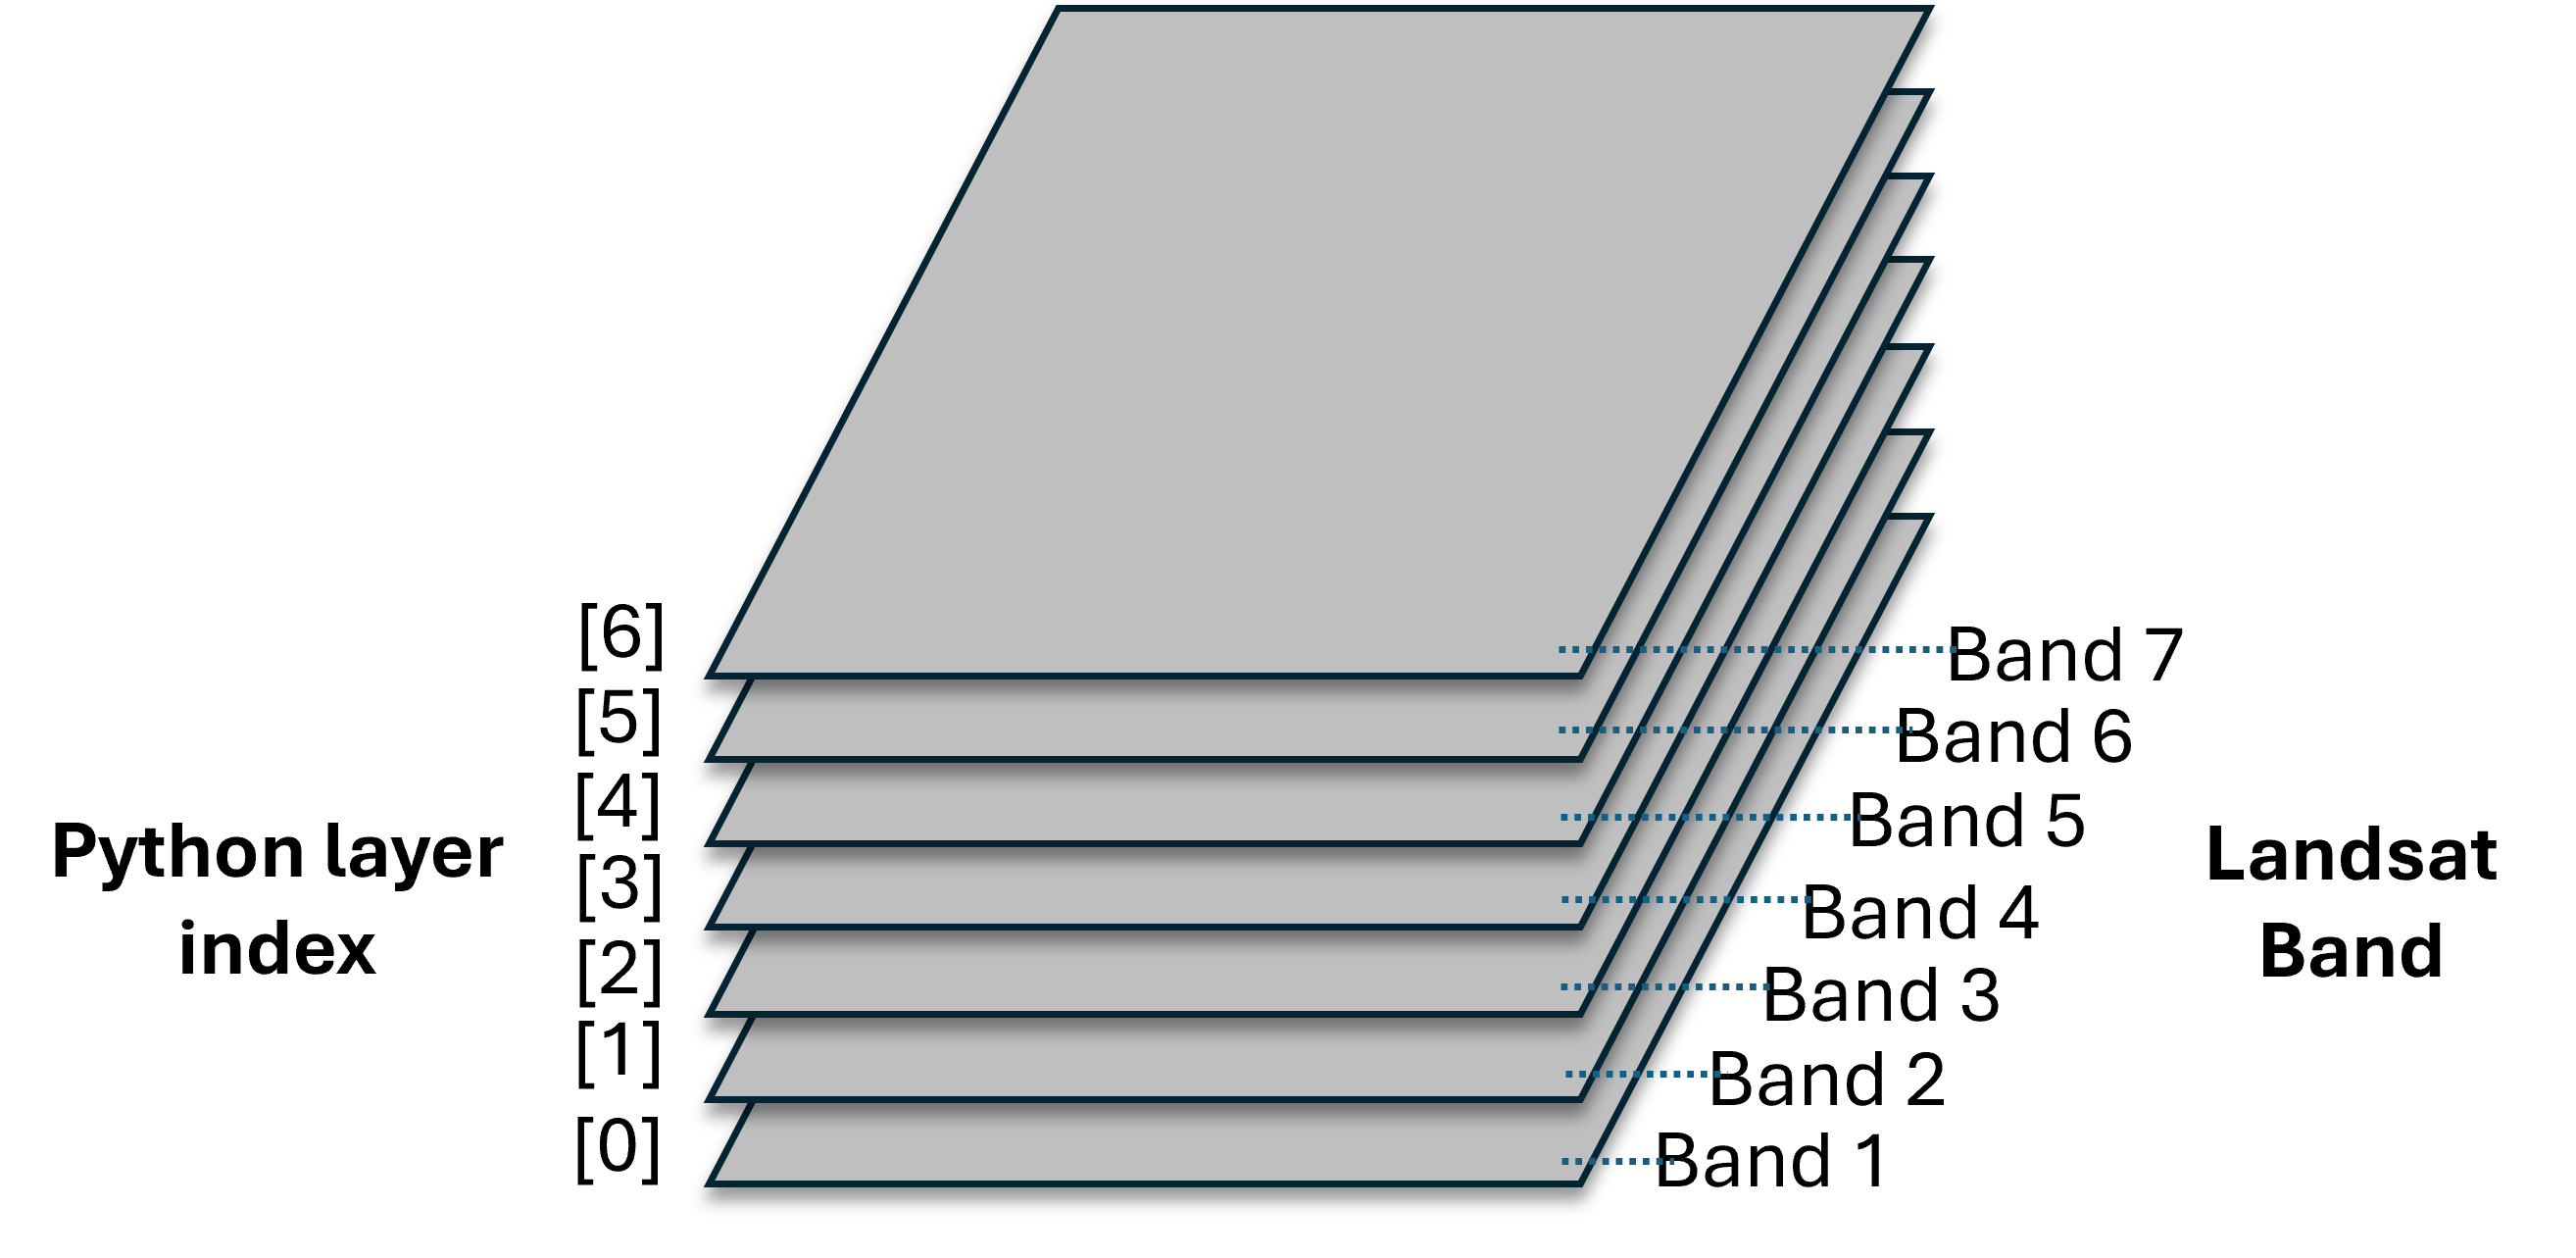

The image above shows a single file, with 7 layers, where each layer contains data for a single Landsat band. When these data are read into a single file in python, we can access each layer individually be referring to the layer index.

Layer indexing in python starts with [0], so a file with 7 layers would have index identifiers going from [0] to [6], as shown in the diagram above.

# Importing data for all Landsat bands into a single file
The easiest way to import data for all bands into a single file is in something called a loop.

First, we can create a list of filenames (i.e. the names we assigned each file when we downloaded them)

In [ ]:
#@title Create a list of filenames

file_names = [f"LangdonBeck_B{i}" for i in [1,2,3,4,5,6,7]]

# This line of code builds a list of filenames using an f-string and a loop.

# [1,2,3,4,5,6,7] is the list of numbers to loop over.

# for i in ... goes through each number in turn.

# f"LangdonBeck_B{i}" is an f-string that inserts the current i into the text.

# So it produces:
#["LangdonBeck_B1", "LangdonBeck_B2", "LangdonBeck_B3",
#"LangdonBeck_B4", "LangdonBeck_B5", "LangdonBeck_B6", "LangdonBeck_B7"]

Then we can use the **rasterio** package to open the data and add it to a single multi-layer file. In the code below, read the comments (green text) to help you understand what each line of code is doing.

In [ ]:
bands = [] # this creates an empty list called "bands" which will be filled when we run the loop.

with rasterio.open(file_names[0]) as LB: # This opens the file and assigns the dataset (i.e. the first dataset in the file list) to LB (short for Langdon Beck!).
    bounds = LB.bounds              # This reads the raster’s bounding box in map coordinates - left, bottom, right, top (e.g., min/max Easting and Northing)
                                    # & assigns it to a variable called bounds.
    landsat_crs = LB.crs                    # This takes the CRS (coordinate reference system) stored in the raster/dataset object LB and assigns it to a variable called crs
    transform = LB.transform        # This helps with pixel-to-map mapping

for f in file_names:                     # This sets up a loop in Python that goes through each item in the list files, one at a time.
                                    # files = a list of filenames that you se up before
                                    # f = the current item from that list during each loop iteration
    with rasterio.open(f) as src:   # This opens the raster file f using rasterio. ' src' is the opened dataset, and is often used to refer to 'source dataset' - you could use any name.
        bands.append(src.read(1))   # This reads the dataset as a NumPy array and adds it to the list bands

                                    # After looping over several files, bands becomes a list like:
                                    # bands[0] = array from first file
                                    # bands[1] = array from second file etc.

stack = np.stack(bands, axis=0)     # this combines the individual bands into a single raster image with multiple bands (a 3D array (bands, rows, cols).

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top] # This builds a 4-number list called 'extent' from the raster’s bounding box, which will be used subsequently to plot the data.



# View the shape of the stacked data file that you just created
Earlier, you used the command ``band1.shape`` to view the dimensions of the file named "band1".

Now, modify this command to view the dimensions of the file you have just created, called "stack", enter it in the code block below and run the block.

In [ ]:
# Enter your code in here


You should see that you now have a 3-D dataset.

### Question 4: What are the dimensions of the stacked data file?

# Plotting the data
Here you will use **matplotlib**, which you are already familiar with, to plot out the data.

In [ ]:
#@title Plotting the Landsat data

# plot band 1 with coordinates
plt.figure(figsize=(5, 5))                            # This creates a new figure window that’s 5 inches by 5 inches.
plt.imshow(stack[0], extent=extent, origin="upper")   # This shows stack[0] as an image, and extent=extent tells Matplotlib what coordinates to put on the axes
                                                      # instead of pixel indices. Origin="upper" means the array’s [0,0] element is drawn at the top-left (like most image coordinate systems).
plt.colorbar(label="Pixel value")                     # This adds a colorbar showing how colors map to numeric values, labeled “Pixel value”.
plt.title("Landsat-Band 1")                           # This adds a title to the plot.
plt.xlabel("Easting")                                 # This adds a x axis label to the plot.
plt.ylabel("Northing")                                # This adds a y axis label to the plot.
plt.show()                                            # This renders the figure to the screen/notebook output.

### Question 5: What wavelength range does the figure above show?

# View a different band

Now, have a go at modifying the code you just used to plot out a Band 1, and this time plot out Band 5. Recall that Band 5 is the near infrared (NIR). You can enter the modified code in the code block below:

In [ ]:
# Enter your code here to plot out Band 5.
# ***Hint: copy the code you just ran into here, and change the code to plot out the equivalent figure for Band 5.
# Remember that python indexing starts at [0].

If you have done it correctly, your Band 5 figure should look like this:

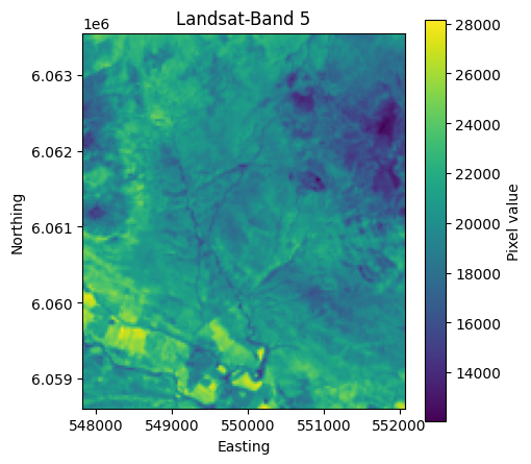

You should be able to pick out high reflectance (more yellow) areas in the valley bottom. This is because Landsat Near-Infrared (NIR) bands detect high reflectance from vegetation chlorophyll and high absorption by water.

# Plotting a true colour composite
Bands 2, 3 and 4 are red, blue, and green bands of the electromagnetic spectrum. These are the band combinations that approximate what you would see with your eyes.

Visualising the data in this way is valuable as you can immediatly recognise broad patterns, e.g. moorland vs rock, reservoirs, bare ground, snow etc. It serves as a baseline for checking processing: helps catch mistakes such as flipped axes, bad masking, wrong CRS, or bands mis-ordered.

Let's have a go at plotting the true colour composite.

First, you'll normalize the data in each of the three bands (e.g. red, green, and blue). This means you rescale the reflectance values so that, in each band, the darkest value becomes 0 and the brightest becomes 255 (the full range for an 8-bit image). Doing this uses the whole brightness range, which boosts contrast and makes features in the image easier to see.

Load the function that you will use to normalize the data:

In [ ]:
# This is the function to normalize the data

def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

Now run the function on the individual bands of the Landsat imagery, which we'll acess from the stacked data, stored in "stack".

Remember that python indexes layers from starting from [0], so band 1 is stack[0].

In [ ]:
# Here, we use the above function (called norm) to normalise the data to put the reflectance values onto a common scale (0-1)
# For now we only need this for the true-colour bands (B4, B3, B2) but let's just to it for all the bands.

# stretch the values for visualization
B1_s, B2_s, B3_s, B4_s, B5_s, B6_s, B7_s = norm(stack[0]), norm(stack[1]), norm(stack[2]), norm(stack[3]), norm(stack[4]), norm(stack[5]), norm(stack[6])

In [ ]:
rgb = np.dstack([B4_s,B3_s,B2_s])

In [ ]:
# plot 3 bands with coordinates
plt.figure(figsize=(5, 5))
plt.imshow(rgb, extent=extent, origin="upper")
plt.title(f"True colour composite")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

The true colour composite image that you've just plotted should look much more familiar to you.

In a traditional GIS you can overay layers (as you did in Term 1). We can do the same here, to overlay the catchment outline for Langdon Beck at flow gauge 25011 over the imagery.

Let's have a go by first importing the catchment outline, and then overlay it on top of the true colour composite image.

To import a shapefile, we need to import it in a zipped file format (provided for you on GitHub), and we need to use the **geopandas** package to open the data.

In [ ]:
# install/load required packages

!pip -q install "geopandas>=0.14"            # First we install the geopandas package as it isn't a default package in colab

import geopandas as gpd                      # Then we load the package.
import requests, zipfile, io

We can now download the data:

In [ ]:
# read in data that's provided for you on Github
url = "https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/nrfa_25011.zip"

# Download the zip file into memory
r = requests.get(url)                         # This downloads whatever is at that URL, in this case a zipped folder containing the catchment data.
z = zipfile.ZipFile(io.BytesIO(r.content))    # This processes the data so that Python can treat it like an in-memory file.

# read in the shapefile
z.extractall("nrfa_25011")                    # This extracts all files from the ZIP into a folder called nrfa_25011 in your current working directory.
LB_25011 = gpd.read_file("nrfa_25011")        # This reads in the catchment outline data using the geopandas package.


As you will recall from the Term 1 GIS sessions, to be able to overlay data correctly, the datasets need to have the same coordinate system.

The shapefile for the Langdon Beck catchment is in the British National Grid coordinate system, so to be able to overlay it (and later on use it to crop the remote sensing data to the catchment outline), we need to reproject it to the coordinate system of the Landsat imagery.

Earlier you saved the coordinate reference system (crs) for the Landsat imagery in "landsat_crs". Let's remind ourselves what this was by printing it out:

In [ ]:
print(landsat_crs)                            # view the coordinate system of the Landsat datset

Have a go at doing a google search to see what coordinate system this "EPSG" code is.

## Question 6: What's the coordinate system of the Landsat data?


In [ ]:
# Reproject vector to raster CRS
catchment = LB_25011.to_crs(landsat_crs)      # This command reprojects the catchment outline (LB_25011) to the same coordinate system as the landsat data, "landsat_crs".

Now that the catchment outline is in the same coordinate system as the Landsat data, we can overlay it on the true colour composite image:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Because we're overlaying the catchment outline, the plotting syntax is a bit different here.
# ax is the Axes object in Matplotlib — basically "the plot area" inside the figure.
# So, ax. means "call a method on that specific axes". This is useful when we're plotting two separate datasets in the same figure.

ax.imshow(rgb, extent=extent, origin="upper")
catchment.boundary.plot(ax=ax, linewidth=2, color = "red")
ax.set_title("Langdon Beck catchment with catchment boundary")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.show()


# Plotting a false colour composite

A false-colour vegetation composite (5-4-3) displays NIR / Red / Green as the Red / Green / Blue channels in the image. For Landsat 9, this means:

* Band 5 = Near-infrared (NIR)
* Band 4 = Red
* Band 3 = Green

This composite is particularly useful because vegetation reflects strongly in the NIR, so areas with healthy, dense plant cover stand out clearly. It often separates vegetation from bare ground more effectively than a true-colour image, which makes it well suited to landscapes like upland moorland, bracken, and woodland patches.

Typical interpretations of false colour composites are:

* Healthy/dense vegetation: bright red
* Sparse/stressed vegetation: dull red or pink
* Bare soil/rock: grey or greenish
* Water: very dark (strong NIR absorption)

To display the false-colour composite properly, we need to combine the three bands into a single 3-channel array (in the same way we built the true-colour RGB image), and then plot it out:

In [ ]:
fcc = np.dstack([B5_s, B4_s, B3_s]) # fcc shorthand for false colour composite

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(fcc, extent=extent, origin="upper")
catchment.boundary.plot(ax=ax, linewidth=2, color = "red")
ax.set_title("FCC with catchment boundary")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.show()

# Plotting a Shortwave Infrared (SWIR) composite

A SWIR composite (7-6-4) displays SWIR2-SWIR1-Red as the Red-Green-Blue channels in the image.

For Landsat 9, this means:

* Band 7 = SWIR2
* Band 6 = SWIR1
* Band 4 = Red

This composite is valuable because the shortwave infrared (SWIR) bands are highly sensitive to moisture: SWIR reflectance generally increases as surfaces dry, so wet peat and saturated soils often look very different from dry mineral surfaces. It also tends to highlight geomorphic and lithologic contrasts, making bare ground, scree, and rocky outcrops stand out. Finally, it provides a useful stepping stone toward disturbance indices such as the Normalised Burn Ratio (NBR) and other SWIR-based change-detection metrics.

Typical interpretations of SWIR composites are:

* Wet areas / water: dark to black
* Dry soils / exposed rock: brighter, often with distinctive tones
* Vegetation: variable, but often darker than dry bare ground in SWIR

As with the false colour composite, to display the SWIR composite, we need to combine the three bands into a single 3-channel array.

Have a go at entering the code yourself, saving the 3 channels as "SWIR".


In [ ]:
# enter your code to the right of the "=" sign:
SWIR =                                                                         # SWIR is shorthand for shortwave infrared composite

And now enter code to plot out the SWIR with the catchment outline.

Note in the figure you have just created where there appear to be more moist areas.

# Calculating indices

Spectral indices are simple combinations of satellite bands designed to highlight a particular surface property, most commonly vegetation “greenness”, surface water/wetness, or regions that have burned.

As we have already seen by visualizing the Landsat data for Langdon Beck, different materials reflect and absorb light differently across wavelengths.

For example, healthy green vegetation reflects strongly in the near-infrared (NIR) but absorbs red light for photosynthesis, while water absorbs strongly in NIR and shortwave infrared (SWIR).

By taking ratios or normalised differences between bands, an index can amplify these contrasts.

A common pattern is the normalised difference form:
$$
\text{Index} = \frac{A - B}{A + B}
$$

This approach keeps values in a consistent range (often around -1 to +1) and makes the index more comparable across space and (later - next week!) across time.

From Landsat 9 Surface Reflectance data, you can calculate a range of indices including the Normalised Difference Vegetation Index, the Enhanced Vegetation Index, and the Normalised Difference Moisture Index.

In the next steps, you'll have a go at calculating these indices.


# Preparing the data to calculate indices

The Landsat level 2 data are provided such that each floating point pixel (this is a data type) has an offset applied and then multiplied by a gain to bring the value into the 16-bit integer (or unsigned integer) range (don't worry too much about the technicalities here). These values are referred to as scaled integers. You may have noticed the resulting large values when plotting out the data for Bands 1 and 5 at the start of this worksheet.

To get the data back to its original Surface Reflectance values for each band, a scale factor and offset are provided. You can read more about this [here](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products) on the USGS website.

So, before we can calculate indices, we need to apply the scale_factor to each pixel and add the offset:

_scaled data = Digital Number * scale factor + offset_

In [ ]:
#@title Apply the scale factor and offset to the data

SCALE  = 0.0000275
OFFSET = -0.2

scaled_data = stack.astype("float32") * SCALE + OFFSET  # convert all bands at once using the "stacked data layer" that we created earlier


# Cropping the data

Ultimately we want to be able to say something quantiative, using remote sensing data, about surface characteristics in the Langdon Beck catchment, but not in the area outside of the catchment.

We therefore need to crop the Landsat scaled values to the catchment polygon.

We can undertake this cropping using tools from the **rasterio** package.

In [ ]:
from rasterio.features import geometry_mask
from rasterio.windows import from_bounds

geoms = [g.__geo_interface__ for g in catchment.geometry]          # This turns the catchment polygon information into a format that the rasterio mask function expects.

# First, we'll crop the data to a bounding box
xmin, ymin, xmax, ymax = catchment.total_bounds  # total_bounds returns the smallest rectangle that contains the whole catchment, in the format of min and max x and y coordinates
win = from_bounds(xmin, ymin, xmax, ymax, transform=transform) # This converts the bounding box into a raster "window", where "transform" maps between pixel indices and actual coordinates

r0, r1 = int(win.row_off), int(win.row_off + win.height) # This converts the window (win) into integer (whole number) row slice indices
c0, c1 = int(win.col_off), int(win.col_off + win.width) # This converts the window (win) into integer (whole number) column slice indices

stack_crop = scaled_data[:, r0:r1, c0:c1] # This crops the raster stack -- the scaled_data, to just that window

# window transform (so mask aligns with the cropped array)
transform_crop = rasterio.windows.transform(win, transform) # This updates the "transform" information to say, "In the real world, where is the top-left pixel of this cropped array?""

# Next, we'll make polygon mask on the cropped grid
inside = ~geometry_mask(
    geoms,
    out_shape=(stack_crop.shape[1], stack_crop.shape[2]),
    transform=transform_crop,
    invert=False
)

# Finally, we'll set outside catchment to NaN (float) so that there are no "digital valuues" in those cells
stack_masked = stack_crop.astype("float32") # This sets the data type
stack_masked[:, ~inside] = np.nan # This sets all pixels outside the catchment to “no data” (NaN) in every band.

# Now you have masked bands as indivudual files that you can work with:
B1_crop, B2_crop, B3_crop, B4_crop, B5_crop, B6_crop, B7_crop = stack_masked[0], stack_masked[1], stack_masked[2], stack_masked[3], stack_masked[4], stack_masked[5], stack_masked[6]


Let's plot one of the bands to check it has plotted correctly:

In [ ]:
# Plot the cropped data
plt.figure(figsize=(5, 5))
plt.imshow(B1_crop, extent=extent, origin="upper")
plt.colorbar(label="Pixel value")
plt.title(f"Band 1 cropped to Langdon Beck catchment")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

The data are now in a format ready for calculating indices.

# Calculating the Normalized Difference Vegetation Index
When calculating the NDVI with Landsat 9 data, we use the following bands:

* NIR = Band 5
* Red = Band 4

and it is calculated as:

$$
\mathrm{NDVI} = \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + \mathrm{Red}}
$$


### Question 7. You've been given the equation to calculate the NDVI. Write out this equation as it should be expressed in python, referring to the correct band numbers (and using the cropped data).

Once you have answered Question 7, add the correct equation into the code block below.

If you got the answer wrong, then you can copy the correct equation given to you in the question feedback.

In [ ]:
# Add the NDVI equation here



Now let's plot out the NDVI, along with a colour ramp:

In [ ]:
# Plot out the NDVI

fig_NDVI, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(NDVI, extent=extent, origin="upper")
# catchment.boundary.plot(ax=ax, linewidth=2, color = "red")    # Here I've commented out the catchment boundary, as the NDVI is only shown for pixels inside the catchment
fig_NDVI.colorbar(im, ax=ax, label="NDVI")
ax.set_title("NDVI for Langdon Beck catchment")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.show()


# The Enhanced Vegetation Index

More recently, the Enhanced Vegetation Index has been proposed, which supposedly does a better job at mapping out vegetation health because it is less prone to saturation in dense vegetation and includes terms that reduce sensitivity to background effects from dark, wet peat surfaces.

The EVI is calculated as:

$$
\mathrm{EVI} = G \, \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + C_1\times\mathrm{Red} - C_2\times\mathrm{Blue} + L}
$$


and with the following values for G, C1 and C2:


$$
\mathrm{EVI} = 2.5 \left( \frac{\mathrm{Band}\ 5 - \mathrm{Band}\ 4}{\mathrm{Band}\ 5 + 6\times\mathrm{Band}\ 4 - 7.5\times\mathrm{Band}\ 2 + 1} \right)
$$

This equaton is entered into python as:



In [ ]:
# Calculate the EVI

EVI  = 2.5 * ((B5_crop - B4_crop) / (B5_crop + 6*B4_crop - 7.5*B2_crop + 1))

The next step is to view the EVI. HAve a go at plotting this out by yourself.

In [ ]:
# add your own code to plot out the EVI
# ***HINT***: you will gind it useful to reuse previous code!


# Comparing the NDVI and EVI
To undertake a visual comparison of the two vegetation indices, we can replot them to view them side-by-side.

To do this, we use a ``plt.sublots`` command

In [ ]:
fig_NDVI_EVI, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# We're going to show a single colour ramp for both indices, so we're going to set the range of values to be displayed in each image to be between 0 and 1:
vmin = 0
vmax = 1

# NDVI
im1 = ax1.imshow(NDVI, extent=extent, origin="upper", vmin=vmin, vmax=vmax)
ax1.set_title("NDVI")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")

# EVI
im2 = ax2.imshow(EVI, extent=extent, origin="upper", vmin=vmin, vmax=vmax)
ax2.set_title("EVI")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")

# One colourbar for both plots
cbar = fig_NDVI_EVI.colorbar(im1, ax=[ax1, ax2], label="Index value")

plt.show()


We can view the relation between the pixel-lelve values of the NDVI and the EVI by creating a scatter plot of all values in the two raster layers. Let's have a go:

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(NDVI, EVI, s=1)
plt.xlabel("NDVI")
plt.ylabel("EVI")
plt.title("Pixel-wise relationship: NDVI vs EVI")

# adding a 1:1 line to the plot
plt.plot([vmin, vmax], [vmin, vmax], linestyle="--", color = "red")  # y = x
plt.xlim(vmin, vmax)                                             # This sets the visible range of the x axis.
plt.ylim(vmin, vmax)                                             # This sets the visible range of the y axis.
plt.show()

In this figure you should see a big concentration of pixels around NDVI ~0.7 - 0.9, and within that relatively narrow NDVI range, EVI still spans a fairly wide range (roughly ~0.4 - 0.85).

This pattern is consistent with NDVI losing sensitivity at the top end while EVI continues to differentiate vegetation differences (because EVI is designed to be less saturating and to reduce background effects).

So, in summary we see that lots of pixels have similarly high NDVI, but their EVI varies a lot, meaning that the NDVI is starting to 'top out' and compress differences among the greenest parts of the catchment.

As a final bit of data exploration here, we can create a boxplot, to summarise the overall distribution of NDVI and EVI values within Langdon Beck catchment.

To plot the data nicely, side-by-side for each image, it's much easier to join the two indices into a single stack, in the same way we've done before:

In [ ]:
# stack the two 2D arrays into shape (2, rows, cols)
indices = np.stack([NDVI, EVI])

Then we can create a box plot. To create a boxplot in python the data need to be stored in a 1D array (i.e. a list, rather than a matrix format).

The first bit of code below re-structures the 2D array into a 1D array.

Then, we can create a boxplot.

In [ ]:

data = []                             # Creates an empty container called data
for i in range(2):                    # Loops through each layer in the "indices" stacked layer you just created
    vals = indices[i].ravel()         # This takes the i-th 2D raster layer and flattens it into a 1D list of pixel values.
    vals = vals[np.isfinite(vals)]    # This Keeps only valid numbers (drops NaN values) so NoData values don't mess up the boxplot.
    data.append(vals)                 # This adds that 1D array to data.

# creating the boxplot
plt.figure(figsize=(4, 4))
plt.boxplot(data, tick_labels=["NDVI", "EVI"], showfliers=False)
plt.ylabel("Value")
plt.title("NDVI and EVI (catchment)")
plt.show()

# Spatial variations in moisture content across the catchment

In the Langdon Beck catchment, it's useful to understand how wetness varies across the landscape, because this influences runoff generation, connectivity, and which parts of the catchment contribute flow during events. We can't directly and reliably measure soil moisture from Landsat. Instead, we can calculate the Normalized Difference Moisture Index (NDMI), which uses near-infrared and shortwave-infrared reflectance to estimate the moisture content of vegetation canopies. In Langdon Beck, NDMI often provides a helpful proxy for catchment wetness because vegetation water status tends to respond to (and therefore partially reflect) underlying soil moisture conditions, especially across contrasts in peat/organic soils, grass/heather cover, and topographic wetness.

The NDMI is expressed as:

$$
\mathrm{NDMI} = \frac{\mathrm{NIR} - \mathrm{SWIR1}}{\mathrm{NIR} + \mathrm{SWIR1}}
$$


or with specific reference to Landsat 9 bands as:


$$
\mathrm{NDMI} = \frac{\mathrm{Band}\ 5 - \mathrm{Band}\ 6}{\mathrm{Band}\ 5 + \mathrm{Band}\ 6}
$$

On your own, have a go at entering the code to calculate the NDMI for Langdon Beck.

In [ ]:
# Enter your code here:


In [ ]:
mean_ndmi = np.nanmean(**enter the name of your ndmi output here**) # On this line of code, the mean value of the ndmi layer is calculated,
                                                                    # but it ignores the no data values that form the mask around the catchment



And once you've done this, plot out a map of the NDMI for Langdon Beck.

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(NDMI, extent=extent, origin="upper")
plt.colorbar(label="NDMI")
plt.title(f"NDMI for Langdon Beck")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

We could then explore the relation between the EVI and the NDMI to see how well vegetation condition relates to vegetation moisture content.

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(EVI, NDMI, s=1)
plt.xlabel("EVI")
plt.ylabel("NDMI")
plt.title("Pixel-wise relationship: EVI and NDMI")
plt.show()

# Comparing remote sensing indices to field measurements of surface cover type

As a final step in this workshop, you'll explore how the remote sensing indices you've calculated vary across the different surface cover types you identified when you measured hillslope profiles in the Langdon Beck catchment.

Conveniently, your hillslope profile datasets (mostly) include a surface cover description at each measurement location, along with a GPS coordinate.

In the next few steps, we'll organise the surface cover data and then extract the EVI and NDMI values at each of those locations. We can then do some simple exploratory analysis to see how these indices differ between surface cover types.

# Accessing the surface cover data
The surface cover data you collected is provided for you on GitHub in a .csv file format. In the following code block you will import the **pandas** library which is one of the main libraries in python used for analysing dataframes.


In [ ]:
import pandas as pd

url = "https://github.com/laura-turnbull-lloyd/IGR_remote_sensing/raw/refs/heads/main/Data/Surface_cover.csv"

df = pd.read_csv(url, na_values=["", " "])  # treat empty strings as NA
df["Easting"]  = pd.to_numeric(df["Easting"], errors="coerce") # This forces the data to be read in a numeric format.
df["Northing"] = pd.to_numeric(df["Northing"], errors="coerce")

df.head() # This allows you do view the header information of the dataframe.

See how many unique values there are in the "Surface_cover" column

In [ ]:
# how many unique text values?
df["Surface_cover"] = df["Surface_cover"].astype(str).str.strip()

unique_vals = df["Surface_cover"].unique()
print("Number of unique values:", len(unique_vals))
print("Unique values:", unique_vals)

# (optional) counts of each
print(df["Surface_cover"].value_counts())

In this list of different surface cover types, you will see that there are many different descriptions of surface cover. To be able to do any meaningful exploratory analysis of variations in the EVI and NDMI between surface cover types, we need to provess these descriptors so that we end up with a few meaningful surface cover classidications.

The following bit of code groups all names containing grass into the same class.

In [ ]:

# Standardise text column
s = df["Surface_cover"].astype(str).str.strip() # This forces all the data in the Surface_cover column to be in the same format.

# Here, the code creates a new column in the dataframe called "Surface_cover_new", to which you will write the new surface cover class name.
df["Surface_cover_new"] = np.select(
    [
        s.str.contains(r"grass", case=False, na=False), # this says that if a description contains the word grass, then it should be classed as grass.
        s.str.contains(r"river|bank|stream", case=False, na=False), # or if it contains any of these words it should be classed as river/bank
        s.str.contains(r"reed", case=False, na=False),              # and so on.....
        s.str.contains(r"rock|Rocks|ridge|stones|Cliff", case=False, na=False),
        s.str.contains(r"peat|bog|moss", case=False, na=False),
        s.str.contains(r"heather|thistles", case=False, na=False),
        s.str.contains(r"Drift|mound|mud|little vegetation|soil|sediment|lack of vegetation|mining heap|gravel|Made ground|Mining waste", case=False, na=False),
    ],
    [
        "grass",
        "river/bank",
        "reeds",
        "rocks",
        "peat",
        "heather/thistles",
        "soil",
    ],
    default=s  # keep original text if no rule matches
)


Let's check now how many unique surface cover types we now have:

In [ ]:
# how many unique text values?
df["Surface_cover_new"] = df["Surface_cover_new"].astype(str).str.strip()

unique_vals = df["Surface_cover_new"].unique()
print("Number of unique values:", len(unique_vals))
print("Unique values:", unique_vals)

# (optional) counts of each
print(df["Surface_cover_new"].value_counts())

We're not interested in the rows of data that have "nan" values, so we can remove these.

In [ ]:
#now remove all rows with na values
df = df[df["Surface_cover_new"].astype(str).str.strip() != "nan"].copy() # That line filters out rows where Surface_cover_new is missing, then makes a copy of the result.

What we're going to do next is see if there are differences in the indices we've calculated from the landsat data, for different surface cover types that you mapped out in the field.

To do this we need to convert the coordinates of the field data (in British National Grid), into the same coordinate system as the Landsat data.

In [ ]:
df["Easting"] = df["Easting"] + 300000 # 300 km offset for easting in metres
df["Northing"] = df["Northing"] + 500000 # 500 km offset for northing in metres

In [ ]:
xcol, ycol = "Easting", "Northing" # here we're specifying which is our xcol and which is the ycol

In [ ]:
# make a GeoDataFrame in British National Grid
gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df[xcol], df[ycol]),
    crs="EPSG:27700"
)

In [ ]:
# reproject to the Landsat CRS (your rasterio CRS stored in `crs`)
gdf = gdf.to_crs(landsat_crs)

In [ ]:
# gdf now has coordinates in Landsat CRS
gdf[["x_landsat", "y_landsat"]] = gdf.geometry.apply(lambda p: (p.x, p.y)).apply(pd.Series)
gdf.head()

In [ ]:
# Convert map x/y -> raster row/col
rows, cols = rasterio.transform.rowcol(
    transform,
    gdf.geometry.x.values,
    gdf.geometry.y.values
)

rows = np.array(rows)
cols = np.array(cols)

# Prepare output
evi_vals = np.full(len(gdf), np.nan, dtype="float32")
ndmi_vals = np.full(len(gdf), np.nan, dtype="float32")

# Keep only points inside the raster
inside = (
    (rows >= 0) & (rows < EVI.shape[0]) &
    (cols >= 0) & (cols < EVI.shape[1])
)

# Sample
evi_vals[inside] = EVI[rows[inside], cols[inside]].astype("float32")
ndmi_vals[inside] = NDMI[rows[inside], cols[inside]].astype("float32")

# Add to table
gdf["EVI"] = evi_vals
gdf["NDMI"] = ndmi_vals


The text above "invalid value encountered" indicates a problem with some of the coordinates. You could explore this further by plotting out the locations of the coordinates in the geodataframe.

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(gdf.x_landsat, gdf.y_landsat, s=5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Point locations from gdf")
plt.axis("equal")
plt.show()

Now for the fun bit: let's see how the EVI values vary in relation to the mapped out surface cover types.

In [ ]:
var = "EVI"
group = "Surface_cover_new"

# Clean the grouping column: blanks/"nan"/"NaN" -> real NaN
gdf[group] = gdf[group].astype(str).str.strip()
gdf.loc[gdf[group].str.lower().isin(["", "nan", "none"]), group] = np.nan

cats = gdf[group].dropna().unique()
data = [gdf.loc[gdf[group] == c, var].dropna().values for c in cats]
labels = [str(c) for c in cats]

plt.figure(figsize=(8, 4))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.ylabel(var)
plt.xlabel("Surface cover type")
plt.xticks(rotation=45, ha="right")
plt.title(f"{var} by {group}")
plt.tight_layout()
plt.show()

Have a go at repurposing the code from above to view the NDMI values by surface cover type.

In [ ]:
# enter your code here:

Here, reflect on potential issues in relating the data you collected in the field to the Landsat-derived indices.

# Saving your work
If you want to save any of the figures you have created, you can add the following line to your plotting commands, making sure you change the output file name accordingly (so in this example, "ndvi_evi.png":

plt.savefig("ndvi_evi.png", dpi=300, bbox_inches="tight")

This approach is best as the "dpi" command allows you to specify the resolution of the image. Once you have saved the figure, in colab you can clock on the folder icon, on the left side of the screen, and you should see your file in your google drive, which you can then save to your desktop or elsewhere.

An alternative approach is to right-click on an image, and select "copy image".



# Summary

That's it for this week. Hopefully you now have a sense of remote sensing imagery, and some of the simple analyses you can do with it to be able to extract spatially continuous information about some property of the surface in the form of indices.

You've then had a go at relating these indices to surface characteristics observations that you collected during field work.

Next week we'll continue working with remote sensing data, to explore how conditions change over time.

----
Laura Turnbull-Lloyd, IGR, 2026.